# Temporalis demonstration notebook

This notebook demonstrates the use of the [Temporalis](http://temporalis.readthedocs.io/en/latest/) software. You should probably also know about the [Brightway2 LCA framework](http://brightwaylca.org/).

In [2]:
import bw2temporalis
print("Temporialis version:", bw2temporalis.__version__)
assert bw2temporalis.__version__ >= (1, 0), "Temporalis needs to be upgraded!"

Temporialis version: (1, 0, 'RC2')


In [3]:
from brightway2 import *
from bw2temporalis import *
import numpy as np

In [4]:
if "tempo_demo" not in list(projects):
    projects.create_project("tempo_demo")
projects.set_current("tempo_demo")

In [5]:
if "biosphere3" not in databases:
    create_default_biosphere3()

In [6]:
ei = SingleOutputEcospold2Importer(
    "/media/giuseppec/25F62A4E5FEED162/work/LCA_db-software/ecoinvent/current_Version_3.2_cutoff_ecoSpold02/datasets", #CHANGE WITH THE FILEPATH OF YOUR ECOINVENT 3.2 CUTOFF
    "ecoinvent 3.1 cutoff"
)
ei.apply_strategies()
ei.write_database()

Extracting XML data from 12916 datasets
Extracted 12916 datasets in 23.87 seconds
Applying strategy: normalize_units
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspecified_subcategories
Applying strategy: link_biosphere_by_flow_uuid
Applying strategy: link_internal_technosphere_by_composite_code
Applying strategy: delete_exchanges_missing_activity
Applying strategy: delete_ghost_exchanges
Applying strategy: remove_uncertainty_from_negative_loss_exchanges
Applying strategy: fix_unreasonably_high_lognormal_uncertainties
Applying strategy: set_lognormal_loc_value
Applied 15 strategies in 2.91 seconds


Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:02:23


Title: Writing activities to SQLite3 database:
  Started: 03/04/2018 08:02:09
  Finished: 03/04/2018 08:04:32
  Total time elapsed: 00:02:23
  CPU %: 36.00
  Memory %: 11.59
Created database: ecoinvent 3.1 cutoff


Brightway2 SQLiteBackend: ecoinvent 3.1 cutoff

In [7]:
ei = None
db = Database("ecoinvent 3.1 cutoff")
len(db)

12916

In [8]:
databases['ecoinvent 3.1 cutoff']['static'] = True
databases.flush()

## Creating a temporal inventory database

In [9]:
METHANE = ('biosphere3', '0795345f-c7ae-410c-ad25-1845784c75f5')  # Methane, fossil, air, kg
CO2 = ('biosphere3', '349b29d1-3e58-4c66-98b9-9d1a076efd2e')      # CO2, fossil, air, kg

In [10]:
data = {
    ('example', 'Functional Unit'): {
        'exchanges': [
            {
                'amount': 5,
                'input': ('example', 'EOL'),
                'temporal distribution': [
                TemporalDistribution(np.array([ 0,  1,  2,  3,  4],dtype='timedelta64[Y]') ,np.array([1.0, 1.0, 1.0, 1.0, 1.0])),
                ],
                'type': 'technosphere'
            },
        ],
        'name': 'Functional Unit',
        'type': 'process'
    },
    ('example', 'EOL'): {
        'exchanges': [
            {
                'amount': 0.8,
                'input': ('example', 'Waste'),
                'type': 'technosphere'
            },
            {
                'amount': 0.2,
                'input': ('example', 'Landfill'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('example', 'Use'),
                'type': 'technosphere'
            },
        ],
        'name': 'EOL',
        'type': 'process'
    },
    ('example', 'Use'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('example', 'Production'),
                'temporal distribution': TemporalDistribution(np.array([4],dtype='timedelta64[M]') ,np.array([1.0])),
                'type': 'technosphere'
            },
        ],
        'name': 'Use',
        'type': 'process'
    },
    ('example', 'Production'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('example', 'Transport'),
                'temporal distribution': TemporalDistribution(np.array([200],dtype='timedelta64[D]') ,np.array([1.0])),
                'type': 'technosphere'
            },
        ],
        'name': 'Production',
        'type': 'process'
    },
    ('example', 'Transport'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('example', 'Sawmill'),
                'type': 'technosphere'
            },
            {
                'amount': 0.1,
                'input': CO2,
                'type': 'biosphere'
            },
        ],
        'name': 'Production',
        'type': 'process'
    },
    ('example', 'Sawmill'): {
        'exchanges': [
            {
                'amount': 1.2,
                'input': ('example', 'Forest'),
                'temporal distribution': TemporalDistribution(np.array([14],dtype='timedelta64[M]') ,np.array([1.2])),
                'type': 'technosphere'
            },
            {
                'amount': 0.1,
                'input': CO2,
                'type': 'biosphere'
            },
        ],
        'name': 'Sawmill',
        'type': 'process'
    },
    ('example', 'Forest'): {
        'exchanges': [
            {
                'amount': -.2 * 6,
                'input': CO2,
                'temporal distribution': TemporalDistribution(np.array([-4,-3,0,1,2,5],dtype='timedelta64[Y]') ,np.array([-.2]*6)),             
                'type': 'biosphere'
            },
            {
                'amount': 1.5,
                'input': db.random(),
                'temporal distribution': TemporalDistribution(np.array([-3,0,1],dtype='timedelta64[Y]') ,np.array([.5]*3)),
                'type': 'technosphere'
            },
        ],
        'name': 'Forest',
        'type': 'process'
    },
    ('example', 'Thinning'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('example', 'Thinning'),
                'type': 'production'
            },
            {
                'amount': 1,
                'input': ('example', 'Avoided impact - thinnings'),
                'type': 'production'
            },
        ],
        'name': 'Thinning',
        'type': 'process'
    },
    ('example', 'Landfill'): {
        'exchanges': [
            {
                'amount': 0.1,
                'input': METHANE,
                'temporal distribution': TemporalDistribution(np.array([10,20,40,60],dtype='timedelta64[M]') ,np.array([0.025]*4)), 

                'type': 'biosphere'
            },
        ],
        'name': 'Landfill',
        'type': 'process'
    },
    ('example', 'Waste'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('example', 'Waste'),
                'type': 'production'
            },
            {
                'amount': 1,
                'input': ('example', 'Avoided impact - waste'),
                'type': 'production'
            },
        ],
        'name': 'Waste',
        'type': 'process'
    },
    ('example', 'Avoided impact - waste'): {
        'exchanges': [
            {
                'amount': -0.6,
                'input': CO2,
                'type': 'biosphere'
            },
            {
                'amount': 1,
                'input': ('example', 'Avoided impact - waste'),
                'type': 'production'
            },
        ],
        'name': 'Avoided impact - waste',
        'type': 'process'
    },
    ('example', 'Avoided impact - thinnings'): {
        'exchanges': [
            {
                'amount': -0.2,
                'input': CO2,
                'type': 'biosphere'
            },
            {
                'amount': 1,
                'input': ('example', 'Avoided impact - thinnings'),
                'type': 'production'
            },
        ],
        'name': 'Avoided impact - thinnings',
        'type': 'process'
    }
}

db = Database("example")
db.write(data)

Writing activities to SQLite3 database:
0%        100%
[############] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/04/2018 08:05:59
  Finished: 03/04/2018 08:05:59
  Total time elapsed: 00:00:00
  CPU %: 171.20
  Memory %: 12.05


## Create static LCIA method

Note the units will be different from the dynamic method; this is watts/m2.

Values from 2013 assessment report.

In [11]:
if ('IPCC 2013 100',) not in methods:
    standard_ipcc = Method(('IPCC 2013 100',))
    standard_ipcc.register()
    standard_ipcc.write([
        [CO2, 1],
        [METHANE, 34]
    ])

## Create dynamic methods

Adapted from [co-fire library](https://github.com/gschivley/co-fire).

Units are degree Kelvin.

In [12]:
if "GTP OP base" not in dynamic_methods:
    create_climate_methods()

## Check static LCA scores

In [13]:
lca = LCA({('example', 'EOL'): 1}, ('IPCC 2013 100',))
lca.lci()
lca.lcia()
lca.score

-0.07263845703390848

In [14]:
from bw2analyzer import ContributionAnalysis

ContributionAnalysis().annotated_top_processes(lca)

[(-1.4400001144409205, 1.200000047683716, 'Forest' (None, None, None)),
 (0.68000002026557926, 0.20000000298023221, 'Landfill' (None, None, None)),
 (0.48000002622604393,
  -0.80000001192092884,
  'Avoided impact - waste' (None, None, None)),
 (0.10000000149011612, 1.0, 'Production' (None, None, None)),
 (0.10000000149011612, 1.0, 'Sawmill' (None, None, None)),
 (0.0028566315001886501,
  0.039063711219791276,
  'diesel, burned in building machine' (megajoule, GLO, None)),
 (0.0011269206609561073,
  0.0013272254984801112,
  'pig iron production' (kilogram, GLO, None)),
 (0.0009430913431745945,
  0.028028771935282557,
  'transport, freight train, diesel' (ton kilometer, US, None)),
 (0.00029406377797901769,
  0.014050243263667181,
  'transport, freight train, diesel' (ton kilometer, CN, None)),
 (0.00028436137444581968,
  0.0013935867101170733,
  'sinter production, iron' (kilogram, GLO, None)),
 (0.0002677534900121092,
  0.00031926980399949779,
  'clinker production' (kilogram, RoW, Non

In [15]:
ContributionAnalysis().annotated_top_emissions(lca)

[(-0.75295701902501178,
  -0.75295701902501144,
  'Carbon dioxide, fossil' (kilogram, None, ('air',))),
 (0.68031856199110252,
  0.020009369470326544,
  'Methane, fossil' (kilogram, None, ('air',))),
 (0.0,
  5.5368134717318074e-07,
  'Carbon dioxide, non-fossil, from calcination' (kilogram, None, ['air'])),
 (0.0,
  2.0971338335785255e-18,
  'Transformation, to permanent crop, non-irrigated, intensive' (square meter, None, ('natural resource', 'land'))),
 (0.0,
  1.0519715518320957e-07,
  'Transformation, to grassland, natural (non-use)' (square meter, None, ('natural resource', 'land'))),
 (0.0,
  1.431862894653485e-07,
  'Transformation, to heterogeneous, agricultural' (square meter, None, ('natural resource', 'land'))),
 (0.0,
  2.3290445611374089e-06,
  'Transformation, to industrial area' (square meter, None, ('natural resource', 'land'))),
 (0.0,
  3.3268751562579908e-11,
  'Transformation, to inland waterbody, unspecified' (square meter, None, ('natural resource', 'land'))),
 (

## Dynamic LCA

In [16]:
%matplotlib inline

In [17]:
from matplotlib import pyplot as plt
import numpy as np

In [18]:
dlca = DynamicLCA({('example', 'EOL'): 1}, ("GTP OP base", "worst case"))
timeline = dlca.calculate()

In [19]:
dlca.timeline = Timeline()
dlca.gt = GraphTraversal()
dlca.heap = []
dlca.calc_number = 0

In [21]:
dlca.gt_results = dlca.gt.calculate(
    dlca.demand,
    dlca.worst_case_method,
#     **dlca.gt_kwargs
)

In [22]:
characterized = timeline.characterize_dynamic("GTP OP base")

In [23]:
%matplotlib inline

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)

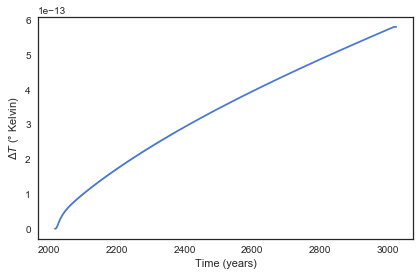

In [25]:
plt.plot(*characterized)
plt.xlabel("Time (years)")
plt.ylabel(r"$\Delta T$ (° Kelvin)")
plt.tight_layout()